# Zero-shot Image Classification with OpenAI's CLIP

State-of-the-art (SotA) computer vision (CV) models are characterized by a restricted understanding of the visual world based on their training data [1].

These models can perform very well on specific tasks and datasets, but they do not generalize well. They cannot handle new classes or images beyond the domain they have been trained with.

This brittleness can be a problem for building niche image classification use-cases, such as defect detection in agriculture to identifying false banknotes to fight fraud. It can be extraordinarily hard to gather labeled datasets that are large enough to fine-tune CV models with traditional methods for those specialized use cases.

Ideally, a CV model should learn the contents of images without excessive focus on the specific labels it is initially trained to understand. With an image of a dog, the model should understand that a dog is in the image. But it would be a lot more useful if it could also understand that there are trees in the background, that it is daytime, and that the dog is on a grassy field.

Unfortunately, the result of classification training is the opposite. Models learn to push their internal representations of dogs into the same “dog vector space” and cats into the same “cat vector space”. All that matters is the binary yes/no as to whether an image aligns with a class.

Retraining classification models is an option, but training requires significant time and capital investment for gathering a classification dataset and the act of model training itself.

Fortunately, OpenAI’s CLIP has proved itself as an incredibly flexible classification model that often requires zero retraining. In this chapter, we will explore zero-shot image classification using CLIP.

![CLIP-Model](./images/CLIP-Model.png)

# N-Shot Learning

Before diving into CLIP, let’s take a moment to understand what exactly “zero-shot” is and its significance in ML.

The concept derives from N-shot learning. Here we define N as the number of samples required to train a model to begin making predictions in a new domain or on a new task.

Many SotA models today are pretrained on vast amounts of data like ResNet or BERT. These pretrained models are then fine-tuned for a specific task and domain. For example, a ResNet model can be pretrained with ImageNet and then fine-tuned for clothing categorization.

Models like ResNet and BERT are called “many-shot” learners because we need many training samples to reach acceptable performance during that final fine-tuning step.

Many-shot learning is only possible when we have compute, time, and data to allow us to fine-tune our models. Ideally, we want to maximize model performance while minimizing N-shot requirements.

Zero-shot is the natural best-case scenario for a model as it means we require zero training samples before shifting it to a new domain or task.

CLIP may not be breaking SotA performance benchmarks on specific datasets. Still, it is proving to be a massive leap forward in zero-shot performance across various tasks in both image and text modalities.

The point of CLIP is not SotA performance. However, it’s worth noting that CLIP did beat the previous SotA results on the STL10 benchmark despite never being trained on that dataset.

The zero-shot adaptability of CLIP was found to work across many domains and different tasks. We will be talking about image classification in this article, but it can also be used in multi-modal search/recommendation, object detection, and likely many more as of yet unknown tasks.

In [2]:
!pip install datasets transformers torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 99.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [3]:
# import the imagenette dataset
from datasets import load_dataset

imagenette = load_dataset(
    'frgfm/imagenette',
    '320px',
    split='validation',
    revision="4d512db"
)
# show dataset info
imagenette

Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

Dataset imagenette downloaded and prepared to /root/.cache/huggingface/datasets/frgfm___imagenette/320px/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f. Subsequent calls will reuse this data.


Dataset({
    features: ['image', 'label'],
    num_rows: 3925
})

In [4]:

# check labels in the dataset
set(imagenette['label'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

The dataset contains 10 labels, all stored as integer values. To perform classification with CLIP we need the text content of these labels. Most Hugging Face datasets include the mapping to text labels inside the the dataset info:

In [5]:
# labels names 
labels = imagenette.info.features['label'].names
labels

['tench',
 'English springer',
 'cassette player',
 'chain saw',
 'church',
 'French horn',
 'garbage truck',
 'gas pump',
 'golf ball',
 'parachute']

In [6]:
# generate sentences
clip_labels = [f"a photo of a {label}" for label in labels]
clip_labels

['a photo of a tench',
 'a photo of a English springer',
 'a photo of a cassette player',
 'a photo of a chain saw',
 'a photo of a church',
 'a photo of a French horn',
 'a photo of a garbage truck',
 'a photo of a gas pump',
 'a photo of a golf ball',
 'a photo of a parachute']

Before we can compare labels and photos, we need to initialize CLIP. We will use the CLIP implementation found via Hugging Face transformers.

In [7]:
# initialization
from transformers import CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

In [8]:
import torch

# if you have CUDA set it to the active device like this
device = "cuda" if torch.cuda.is_available() else "cpu"
# move the model to the device
model.to(device)

device

'cuda'

Text transformers cannot read text directly. Instead, they need a set of integer values known as token IDs (or input_ids), where each unique integer represents a word or sub-word (known as a token).

We create these token IDs alongside another tensor called the attention mask (used by the transformer’s attention mechanism) using the processor we just initialized.

In [9]:
# create label tokens
label_tokens = processor(
    text=clip_labels,
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)

label_tokens['input_ids'][0][:10]

tensor([49406,   320,  1125,   539,   320,  1149,   634, 49407],
       device='cuda:0')

Using these transformer-readable tensors, we create the label text embeddings like so:

In [10]:
# encode tokens to sentence embeddings
label_emb = model.get_text_features(**label_tokens)
# detach from pytorch gradient computation
label_emb = label_emb.detach().cpu().numpy()
label_emb.shape

(10, 512)

In [11]:
label_emb.min(), label_emb.max()

(-1.9079255, 6.17163)

The vectors that CLIP outputs are not normalized, meaning dot product similarity will give inaccurate results unless the vectors are normalized beforehand. We do that like so:

In [12]:
import numpy as np

# normalization
label_emb = label_emb / np.linalg.norm(label_emb, axis=0)
label_emb.min(), label_emb.max()

(-0.87605494, 0.89617443)

(Alternatively, you can use cosine similarity)

All we have left is to work through the same process with the images from our dataset. We will test this with a single image first.

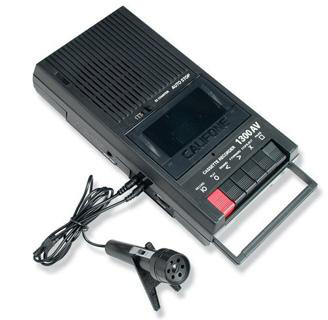

In [13]:
imagenette[0]['image']

In [14]:
image = processor(
    text=None,
    images=imagenette[0]['image'],
    return_tensors='pt'
)['pixel_values'].to(device)
image.shape

torch.Size([1, 3, 224, 224])

After processing the image, we return a single (1) three-color channel (3) image width of 224 pixels and a height of 224 pixels. We must process incoming images to normalize and resize them to fit the input size requirements of the ViT model.

We can create the image embedding with:

In [15]:
img_emb = model.get_image_features(image)
img_emb.shape

torch.Size([1, 512])

In [16]:
img_emb = img_emb.detach().cpu().numpy()

From here, all we need to do is calculate the dot product similarity between our image embedding and the ten label text embeddings. The highest score is our predicted class.

In [17]:
scores = np.dot(img_emb, label_emb.T)
scores.shape

(1, 10)

In [18]:
# get index of highest score
pred = np.argmax(scores)
pred

2

In [19]:
# find text label with highest score
labels[pred]

'cassette player'

Label 2, i.e., “cassette player” is our correctly predicted winner. We can repeat this logic over the entire frgfm/imagenette dataset to get the classification accuracy of CLIP.

In [20]:
from tqdm.auto import tqdm

preds = []
batch_size = 32

for i in tqdm(range(0, len(imagenette), batch_size)):
    i_end = min(i + batch_size, len(imagenette))
    images = processor(
        text=None,
        images=imagenette[i:i_end]['image'],
        return_tensors='pt'
    )['pixel_values'].to(device)
    img_emb = model.get_image_features(images)
    img_emb = img_emb.detach().cpu().numpy()
    scores = np.dot(img_emb, label_emb.T)
    preds.extend(np.argmax(scores, axis=1))

  0%|          | 0/123 [00:00<?, ?it/s]

In [21]:
true_preds = []
for i, label in enumerate(imagenette['label']):
    if label == preds[i]:
        true_preds.append(1)
    else:
        true_preds.append(0)

sum(true_preds) / len(true_preds)

0.9870063694267516

That gives us an impressive zero-shot accuracy of 98.7%. CLIP proved to be able to accurately predict image classes with little more than some minor reformating of text labels to create sentences.

Zero-shot image classification with CLIP is a fascinating use case for high-performance image classification with minimal effort and zero fine-tuning required.

Before CLIP, this was not possible. Now that we have CLIP, it is almost too easy. The multi-modality and contrastive pretraining techniques have enabled a technological leap forward.

From multi-modal search, zero-shot image classification, and object detection to industry-changing tools like OpenAI’s Dall-E and Stable Diffusion, CLIP has opened the floodgates to many new use-cases that were previously blocked by insufficient data or compute.

Resources
[1] A. Radford, et. al., Learning Transferable Visual Models From Natural Language Supervision (2021)

